Deep learning model which takes into account both the products image and text. This is why a multi-modal deep-learning method is required, with its help we can generates such embeddings that comprises of both the product's text and image representation which can help in further downstream tasks for classification and product retrieval

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Libarries

In [2]:
import pandas as pd
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image, display
import imgaug.augmenters as iaa
import glob
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
import tensorflow_hub as hub
from scipy.spatial import distance
import seaborn as sns
from tensorflow.python.keras.layers import Dense, Input, Dropout, Embedding, Activation
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!pip install git+git://github.com/jaredwinick/img2vec-keras.git
from img2vec_keras import Img2Vec

# Sentence Transformers: https://github.com/UKPLab/sentence-transformers
!pip install -U sentence-transformers

  Cloning git://github.com/jaredwinick/img2vec-keras.git to /tmp/pip-req-build-o7hyvkuh
  Running command git clone -q git://github.com/jaredwinick/img2vec-keras.git /tmp/pip-req-build-o7hyvkuh
  Created wheel for img2vec-keras: filename=img2vec_keras-0.2-cp36-none-any.whl size=6203 sha256=d46b9e64053c48973a506ae1d6b7e5fa077fe04cce3afe72f9dc9076c0028a09
  Stored in directory: /tmp/pip-ephem-wheel-cache-fh7knept/wheels/2e/90/3e/18022740db56735624f1fa778b670e7c013bbf4e9b1802e764
Successfully built img2vec-keras
     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 778kB 7.2MB/s 
     |████████████████████████████████| 3.0MB 29.3MB/s 
     |████████████████████████████████| 1.1MB 19.4MB/s 
     |████████████████████████████████| 890kB 40.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-cp36-none-any.whl size=86756 sha256=794b16379030ac1fc0b36d1fbac4def3a408bff6862fa842d9e42192d79ced56
  Stored in directory: /roo

In [4]:
cd '/content/drive/My Drive/Colab Notebooks/Greendeck/'

/content/drive/My Drive/Colab Notebooks/Greendeck


In [5]:
!git clone https://github.com/UKPLab/sentence-transformers.git

fatal: destination path 'sentence-transformers' already exists and is not an empty directory.


In [6]:
cd 'sentence-transformers/'

/content/drive/My Drive/Colab Notebooks/Greendeck/sentence-transformers


In [7]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/Colab%20Notebooks/Greendeck/sentence-transformers
  Found existing installation: sentence-transformers 0.3.0
    Uninstalling sentence-transformers-0.3.0:
      Successfully uninstalled sentence-transformers-0.3.0
  Running setup.py develop for sentence-transformers


In [8]:
from sentence_transformers import SentenceTransformer

# Downloading Sentences Embedding using a Pretrained Model Bert model
bert_pretrained_model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:45<00:00, 8.87MB/s]


### Unzipping Image data



In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Greendeck/images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: netaporter_gb_images/5da81cfa7861c2af6a5a8a89_3.jpg  
  inflating: netaporter_gb_images/5e5d4feb2886bf988492bc5d_4.jpg  
  inflating: netaporter_gb_images/5e5030684c033d42c0c054ff_0.jpg  
  inflating: netaporter_gb_images/5da81bd97f3e301b4504b4bd_4.jpg  
  inflating: netaporter_gb_images/5da821cdb25b035d1d17bb76_2.jpg  
  inflating: netaporter_gb_images/5da821fa6504fb65da005749_1.jpg  
  inflating: netaporter_gb_images/5da82165b25b035d1d17b54c_0.jpg  
  inflating: netaporter_gb_images/5da81f6f6504fb65c4de3ff9_0.jpg  
  inflating: netaporter_gb_images/5da8215ab25b035d1d17b44b_3.jpg  
  inflating: netaporter_gb_images/5da821ce6504fb65da0055c3_3.jpg  
  inflating: netaporter_gb_images/5db80fbcd5424ee1f335232a_0.jpg  
  inflating: netaporter_gb_images/5da820ec6504fb65da004386_3.jpg  
  inflating: netaporter_gb_images/5da823b76504fb65cb261a84_1.jpg  
  inflating: netaporter_gb_images/5da822126504fb65da0059ae_3.jpg  
  inflating

### Exploring the Text file




In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Greendeck/training.csv')
df.head()

,image,name,classes
0,5da821eb7f3e301b4504bb4a_0.jpg,Marc Jacobs Beauty Eye-Conic Longwear Eyeshad...,beauty<makeup<eyeshadow
1,5da81cde7861c2af6a5a88cf_0.jpg,Marc Jacobs Beauty Eye-Conic Longwear Eyeshad...,beauty<makeup<eyeshadow
2,5da8219a6504fb65da0050aa_0.jpg,Prada Wool sweater,clothing<knitwear<fine knit
3,5da821856504fb65cea703cf_0.jpg,Prada Printed silk-satin twill straight-leg p...,clothing<pants<straight leg
4,5da82200b25b035d1d17bec6_0.jpg,Prada Cropped chain-trimmed printed crepe str...,clothing<pants<straight leg


In [ ]:
df.shape

(65714, 3)

In [ ]:
df.isnull().any()

image      False
name       False
classes    False
dtype: bool

In [ ]:
df.describe()

,image,name,classes
count,65714,65714,65714
unique,65714,14264,48
top,5da81ceb7861c2af6a5a898f_2.jpg,Moncler Quilted shell down jacket,clothing<dresses<midi
freq,1,55,4942


# Part 1

## Image Embeddings Input Model

For pretrained image model for representing raw images into embedding space we will be using Img2Vec. Img2Vec uses the ResNet50 model in TensorFlow Keras, pre-trained on Imagenet, to generate image embeddings. 

The library uses 
`model = resnet50.ResNet50(weights='imagenet')`

https://github.com/jaredwinick/img2vec-keras/blob/master/img2vec_keras/img_to_vec.py

In [ ]:
BASE_URL = '/content/netaporter_gb_images/'

In [ ]:
def display_image(image_path_list):
  """Function to display Image"""
  for img_path in image_path_list:
    display(Image(BASE_URL+img_path))

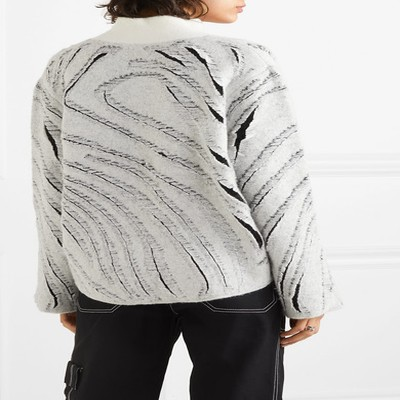

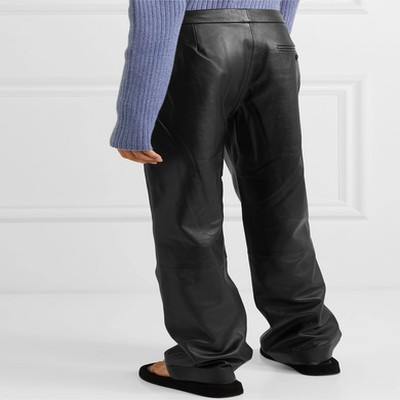

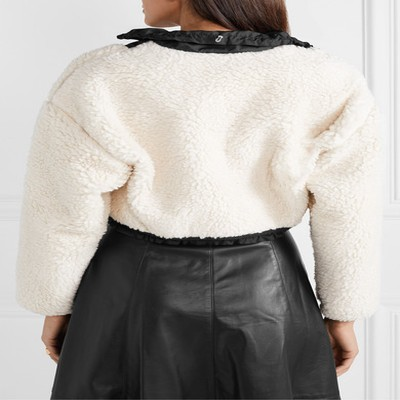

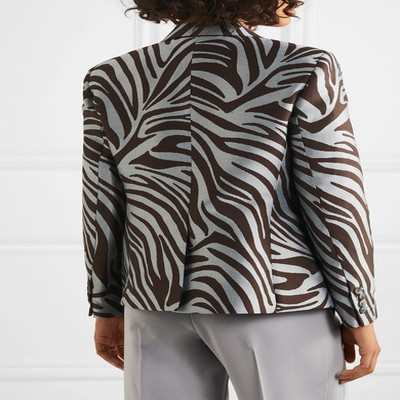

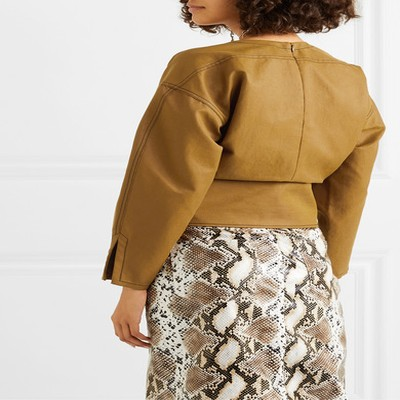

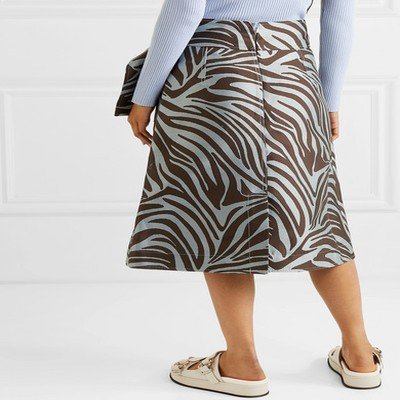

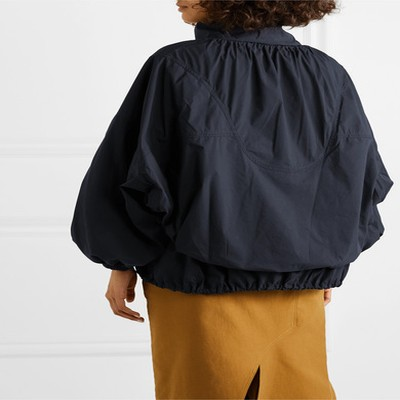

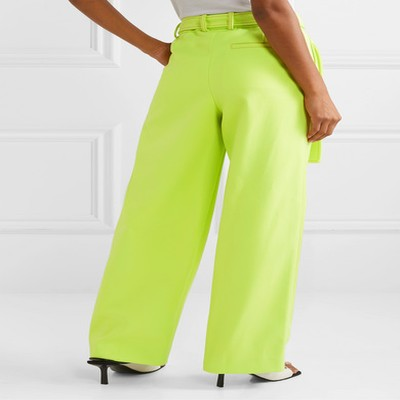

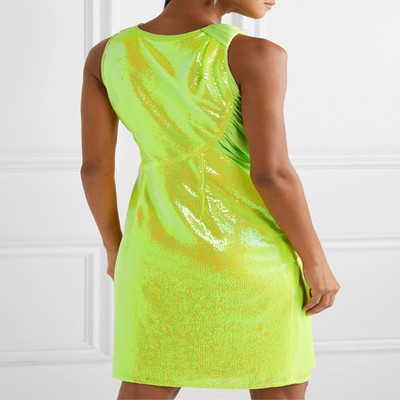

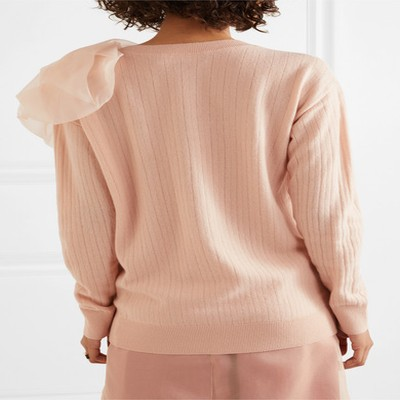

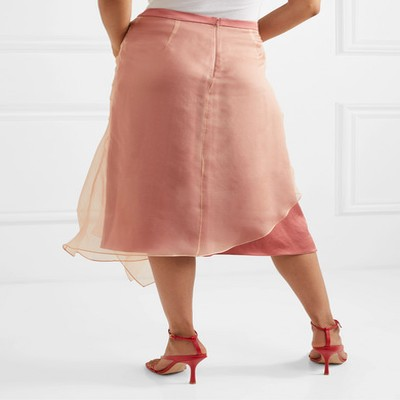

In [ ]:
display_image(df['image'].loc[48020: 48030])

#### Transfer Learning Image

Img2Vec uses the ResNet50 model in TensorFlow Keras, pre-trained on Imagenet, to generate image embeddings
https://github.com/jaredwinick/img2vec-keras

Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

In [ ]:
def get_image_embedding_vector(image_path_list):
  '''
    Input arguments: image_path_list - A list containing the image paths
    Outputs:  A dictionary containing key: image_path and values: embedding vector
  '''
  
  image_embedding_vector = dict()
  img2vec = Img2Vec()

  # seq = iaa.OneOf([
  #   iaa.Fliplr(), # horizontally flip 50% of the images
  #   iaa.Affine(rotate=20), # roatation
  #   iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
  #   iaa.AdditiveGaussianNoise(scale=(10, 60)), #Add noise to images.
  #   iaa.Multiply((1.2, 1.5))]) #random brightness
  
  for image_path in tqdm(image_path_list):
    # augmented_image = seq.augment_image(BASE_URL+image_path)
    vector = img2vec.get_vec(image_path)
    image_embedding_vector[image_path] = vector
    
  return image_embedding_vector  

In [ ]:
image_paths_lst = glob.glob(BASE_URL +  '/*.jpg')

"Tota files in the folder ", len(image_paths_lst)

('Tota files in the folder ', 65714)

In [ ]:
img_vectors = get_image_embedding_vector(image_paths_lst)

100%|██████████| 65714/65714 [39:37<00:00, 27.64it/s]


Saving img_vectors to npy file

In [ ]:
np.save('/content/drive/My Drive/Colab Notebooks/Greendeck/image_embeddings_dict.npy', img_vectors)

In [ ]:
np.save('/content/drive/My Drive/Colab Notebooks/Greendeck/image_embeddings.npy', list(img_vectors.values()))

Loading embeddings from numpy array file. (The operation takes a lot of time (in hours). So it's better to save them as a numpy file so that it could be used again as Google Colab session might interrupt resulting in loss of all the variables and files

In [ ]:
# Loading intial image embeddings obtained by pre trained networks
img_vectors = np.load('/content/drive/My Drive/Colab Notebooks/Greendeck/image_embeddings.npy', allow_pickle=True)

In [ ]:
len(img_vectors) #Checking if length of img_vector is same as the length of the total images

65714

The image embeddings generated from ResNet50 model has shape (1,2048) for each image.


In [ ]:
# Shape of embedding of any arbitrary image
img_vectors['/content/netaporter_gb_images/5da822ad7f3e301b4504bb63_3.jpg'].shape

(2048,)

## Text  Embeddings Input Model


#### Text Preprocessing

In [ ]:
  def remove_unwanted_char(txt):
    txt = txt.replace('-', '')
    txt = txt.replace('&', '')
    txt = re.sub(r"\'m", " am", txt)
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8") #Convert words with accent
    return txt

def preprocessing(txt):
    porter = PorterStemmer() # stemming
    table = str.maketrans('', '', string.punctuation)  # punctuation

    result = remove_unwanted_char(str(txt))      
    result = result.strip() # remove leading and ending spaces
    result = word_tokenize(result) # tokenize
    result = [word for word in result if not word in set(stopwords.words('english'))] # remove stop words
    result = [word for word in result if word.isalpha()] # Considering only aphabets
    result = [w.translate(table) for w in result] # removing punctuations
    result = [porter.stem(word) for word in result]
    result = ' '.join(result)           # Joining all the tokens to string
    return result

In [ ]:
name = df['name'].str.lower() #Name to lowercase
name = name.map(preprocessing)

In [ ]:
name

0        marc jacob beauti eyecon longwear eyeshadow pa...
1        marc jacob beauti eyecon longwear eyeshadow pa...
2                                       prada wool sweater
3             prada print silksatin twill straightleg pant
4        prada crop chaintrim print crepe straightleg pant
                               ...                        
65709                           illamasqua lipstick climax
65710        chloe marci medium texturedleath shoulder bag
65711    gucci sylvi mini leathertrim calf hair shoulde...
65712    marc jacob beauti enamor hishin lip lacquer re...
65713       halfpenni london luella organzatrim satin gown
Name: name, Length: 65714, dtype: object

#### Transfer Learning Text (Bert)

BERT embeddings is used in the paper to obtain a representation of the text.

https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/semantic_search.py

In [ ]:
embedded_texts = bert_pretrained_model.encode(name)

In [ ]:
np.shape(embedded_texts)

(65714, 768)

In the paper, as the number of tokens in each instance of UPMC Food-101 are far greater than the maximum tokens (512) that pre-trained BERT support, text corpus is used as the input to a TF-IDF model and the most important 512 tokens are extracted. 

But in this dataset the max length of the name column is 111. Hence, TF-IDF is not used. 


In [ ]:
# Max length of the string in df['name'] column
df['name'].str.len().max()

111

## Universal Sentence Encoder

Universal Sentence Encoder is used to construct a semantic graph based on the embeddings extracted from the class names.

The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for semantic similarity.

Source: https://tfhub.dev/google/universal-sentence-encoder/4


In [ ]:
def cosine_distance(embedding1, embedding2):
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
    return distance.cosine(embedding1, embedding2)
    
def get_universal_sentence_encoder():
    print("Downloading universal sentence encoder")
    # Using pretrained Universal Sentence Encoder
    encoder_module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    encoder_model = hub.load(encoder_module_url)
    return encoder_model
  

## Semantic Similarity

A semantic graph, which consists of Adjacency matrix which is nothing but matrix of cosine distance between the text embedding representation of individual classes. Such that if you have 5 unique classes, your adjacency matrix will be a 5x5 matrix consisting of cosine distance of text embedding of one class name with all other classes names.

Source: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

In [ ]:
#https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

def plot_similarity(labels, features, rotation):
  """Function to Visualize Similarity"""
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Similarity")

In [ ]:
def get_adj_graph(classes):
    """Return Adjacency matrix of cosine distance between the text embedding of classes"""

    model = get_universal_sentence_encoder()
    print("Loaded universal encoder")
    
    def embed(input):
        return model(input)

    class_embeddings = embed(classes)
    plot_similarity(classes[0:10], class_embeddings[0:10], 90)
    
    n = len(class_embeddings)
    adj_graph_classes = np.zeros([n, n])
    
    for i in range(n):
        for j in range(n):
            adj_graph_classes[i][j] =  cosine_distance(class_embeddings[i], 
                                                      class_embeddings[j])
    return adj_graph_classes

Preprocessing classes before passing to universal sentence encoder 

In [ ]:
df['classes'] = df['classes'].str.replace('<',' ')
all_classes = df['classes'].unique()
all_classes

array(['beauty makeup eyeshadow', 'clothing knitwear fine knit',
       'clothing pants straight leg', 'clothing tops blouses',
       'shoes sandals flat', 'clothing jumpsuits full length',
       'shoes sandals high heel', 'beauty makeup lipstick',
       'beauty makeup foundation', 'beauty makeup lipgloss',
       'beauty skincare moisturizer', 'shoes pumps mid heel',
       'clothing beachwear one-piece', 'shoes sneakers low top',
       'clothing dresses gowns', 'clothing dresses midi',
       'clothing tops shirts', 'clothing tops tanks and camis',
       'clothing jackets blazers', 'clothing tops t-shirts',
       'jewelry and watches fashion jewelry necklaces',
       'shoes sandals mid heel',
       'jewelry and watches fine jewelry necklaces',
       'jewelry and watches fashion jewelry earrings',
       'jewelry and watches fine jewelry rings', 'beauty skincare serum',
       'jewelry and watches fine jewelry earrings',
       'bags shoulder bags shoulder bags', 'bags tote b

In [ ]:
"Total unique classes" , len(all_classes)

('Total unique classes', 48)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


Loaded universal encoder


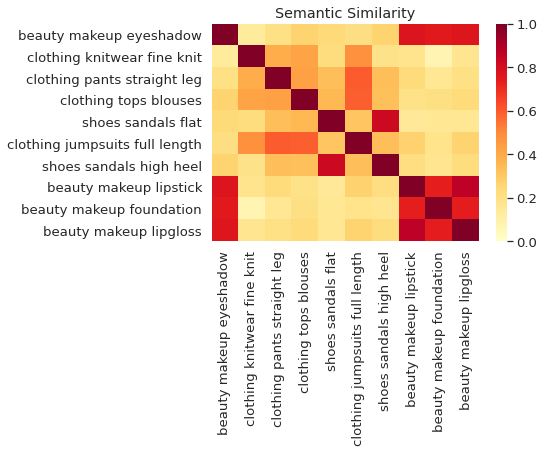

In [ ]:
adj_graph_classes = get_adj_graph(all_classes)

In [ ]:
adj_graph_classes.shape

(48, 48)

# Part 2



## Image Tower Model

The image tower consists of 5 hidden layers of 512 hidden units each. A dropout of 0.15 is used between all hidden layers

In [ ]:
def create_image_tower():
  """Return the Image Tower as mentioned in HUSE"""
  encoded_image_input = Input(shape=(2048, )) #The image embeddings generated from ResNet50 model has shape (1,2048) for each image.

  image_tower = Dense(512, activation='relu')(encoded_image_input)
  image_tower = Dropout(0.15)(image_tower)

  image_tower = Dense(512, activation='relu')(image_tower)
  image_tower = Dropout(0.15)(image_tower)

  image_tower = Dense(512, activation='relu')(image_tower)
  image_tower = Dropout(0.15)(image_tower)

  image_tower = Dense(512, activation='relu')(image_tower)
  image_tower = Dropout(0.15)(image_tower)

  image_tower = Dense(512, activation='relu')(image_tower)
  return encoded_image_input, image_tower

## Text model

The text tower consists of 2 hidden layers of 512
hidden units each. A dropout of 0.15 is used between all hidden layers.

In [ ]:
def create_text_tower():
  """Return the Text Tower as mentioned in HUSE"""
  encoded_text_input = Input(shape=(768, ))
  
  text_tower = Dense(512, activation='relu')(encoded_text_input)
  text_tower = Dropout(0.15)(text_tower)
  text_tower = Dense(512, activation='relu')(text_tower)
  return encoded_text_input, text_tower

## Build Model

In [ ]:
def build_model():
  """Return the final model"""

  shared_hidden_layer = Dense(48, activation='softmax') # As there are total 48 unique classes

  # Normalizing image and text embeddings and passing it to shared_hidden_layer
  encoded_image_input, image_tower = create_image_tower()
  encoded_text_input,  text_tower =  create_text_tower()

  output_image_l2 = shared_hidden_layer(tf.keras.backend.l2_normalize(image_tower))
  output_text_l2 =  shared_hidden_layer(tf.keras.backend.l2_normalize(text_tower))
  
  # models for creating the image and text embedding in the universal shared space
  image_embeddings_model = Model(encoded_image_input, image_tower) 
  text_embeddings_model = Model(encoded_text_input, text_tower)

  # models for obtaining class outout from image or text data
  image_model = Model(encoded_image_input, output_image_l2)
  text_model =  Model(encoded_text_input, output_text_l2)

  model = Model(
      inputs=[encoded_image_input, encoded_text_input], 
      outputs=[output_image_l2, output_text_l2]
  )  # completes the model and assigns inputs and outputs

  return image_embeddings_model, text_embeddings_model, image_model, text_model, model

In [ ]:
image_embeddings_model, text_embeddings_model, image_model, text_model, model = build_model()
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 512)          1049088     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 512)          0           dense_9[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 512)          262656      dropout_5[0][0]                  
___________________________________________________________________________________________

# Part 3

## Class Level Similarity

Simple categorical crossentropy loss using tf.keras.losses.categorical_crossentropy

![Class Level Similarity
 Loss](https://i.ibb.co/CQp6yrp/loss-funcion.jpg)

In [ ]:
def class_level_similarity(y_pred, y_true):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

## Semantic Similarity

In [ ]:
def semantic_similarity():
  pass


## Cross Modal Gap

To reduce the cross modal gap, the distance between image and text embeddings corresponding to the same instance should be minimized. The following loss function is used to achieve instance level similarity.

![cross model gap formula](https://i.ibb.co/Pt7fBvs/cross-modal-gap.jpg)

In [ ]:
def dist(embedding1, embedding2):
    return cosine_distances(embedding1, embedding2)

In [ ]:
def cross_modal_gap(embeddingsImage, embeddingsText):
    distance = dist(embeddingsImage, embeddingsText)
    return (1/batch_size) * np.sum(np.diagonal(distance))

# Part 4

## Training

In [ ]:
history = []
batch_size = 32
threshold = 0.5
alpha, beta, gamma = 1, 1, 1
EPOCHS = 3
LEARNING_RATE=1.6192e-05

In [ ]:
def train_step(images_collection, text_collection, labels_collection, labels_embeddings):
   with tf.GradientTape() as tape:
     image_predictions = image_model(images_collection, training=True)
     text_predictions = text_model(text_collection, training=True)
     
     image_embeddings = image_embeddings_model(images_collection, training=True)
     image_embeddings = tf.keras.backend.l2_normalize(image_embeddings)
     image_embeddings = np.array(image_embeddings)
     
     text_embeddings = text_embeddings_model(text_collection, training=True)
     text_embeddings = tf.keras.backend.l2_normalize(text_embeddings)
     text_embeddings = text_embeddings.numpy()

     classification_loss = class_level_similarity(image_predictions, labels_collection) \
                           + class_level_similarity(text_predictions, labels_batch)

     modal_loss = cross_modal_gap(image_embeddings, text_embeddings) 
     

     total_loss = alpha * classification_loss + gamma * modal_loss
     history.append(total_loss.numpy().mean())

     # optimizing the trainable params
     optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
     grads = tape.gradient(total_loss, model.trainable_variables)
     optimizer.apply_gradients(zip(grads, model.trainable_variables))

     #calculating the accuracy
     predictions = model([images_collection, text_collection])
     predictions = np.array(predictions)
     avg_predictions = predictions[0] + predictions[1]
     correct_labels = np.array([np.argmax(i) for i in labels_batch])
     preds = np.array([np.argmax(i) for i in avg_predictions])
     print("Accuracy ", accuracy_score(correct_labels, preds))



## One Hot Encoding

In [ ]:
class_labels_map = {}
inv_class_labels_map = {}
for i in range(0, 48):
    class_labels_map[i] = all_classes[i]
    inv_class_labels_map[all_classes[i]] = i

In [ ]:
#one hot encoding labels for training
labels = df['classes'].apply(lambda x: x.replace('<', ' '))
labels_num = labels.map(inv_class_labels_map)
labels = to_categorical(labels_num, 48)

In [ ]:
labels_num

0         0
1         0
2         1
3         2
4         2
         ..
65709     7
65710    28
65711    27
65712     9
65713    14
Name: classes, Length: 65714, dtype: int64

In [ ]:
image_embeddings = np.stack(list(img_vectors.values()))
text_embeddings = np.stack(embedded_texts)
labels_embeddings = adj_graph_classes
labels = labels

In [ ]:
text_embeddings.shape

(65714, 768)

In [ ]:
for epoch in range(EPOCHS):
    for i in range(batch_size, len(image_embeddings), batch_size):
        images_batch = image_embeddings[i-32:i]
        texts_batch = text_embeddings[i-32:i]
        labels_batch = labels[i-32:i]
        labels_num_batch = labels_num[i-32:i]
        labels_embeddings_batch = []

        for label in labels_num_batch:
            labels_embeddings_batch.append(labels_embeddings[label])
        
        labels_embeddings_batch = np.array(labels_embeddings_batch)
        
        train_step(images_batch, texts_batch, labels_batch, labels_embeddings_batch)